In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
    
from glob import glob
from tqdm import tqdm
    
import cv2
from PIL import Image
basePath='/home/eric/data/tinymind_multilabel_classification/'
train_path = basePath+'visual_china_train1.csv'
train_df = pd.read_csv(train_path)
train_df.head()

,img_path,tags
0,2074d1cd049f38bb42198e18b23c0443230afb68.jpg,"办公室,白昼,隔断,无人,加利福尼亚,商务,窗户,留白,图像,摄影,公司企业,开放式设计,圣..."
1,40591a781c7a3af93232a83dc2e1665d38b772bf.jpg,"青年人,休闲,白昼,知识,美,树,学校,凝视,时间,衣服,中国人,微笑,表现积极,青年女人,..."
2,d41f7b535f13c15802aa393bc41d2b257992faee.jpg,"想望,美术肖像,尤物,仅一个女人,调情,白人,美人,魅力,微笑,青年女人,女人,信心,美女,..."
3,f7ecc1a8182256885efce7edd40bfd84be6f05fb.jpg,"运动鞋,休闲,运动服,风景,白昼,在活动中,浪漫,家庭,树,动态动作,享乐,马勒,骑马,中国..."
4,09574a46403ab85188404d9383fe7fff51fac3a7.jpg,"灰色,静物,垂直画幅,打结,室内,商务,领带,无人,捕获的,捕获的"


In [12]:
train_df.shape

(35000, 2)

In [13]:
# tags = []
# for i in range(train_df['tags'].shape[0]):
#     for tag in train_df['tags'].iloc[i].split(','):
#         tags.append(tag)

# tags = set(tags)
# len(tags)

In [14]:
img_paths = list(train_df['img_path'])

In [15]:
def hash_tag(filepath):
    fo = open(filepath, "r",encoding='utf-8')
    hash_tag = {}
    i = 0
    for line in fo.readlines():     #依次读取每行  
        line = line.strip()         #去掉每行头尾空白  
        hash_tag[i] = line
        i += 1
    return hash_tag

def load_ytrain(filepath):  
    y_train = np.load(filepath)
    y_train = y_train['tag_train']
    
    return y_train

def arr2tag(arr):
    tags = []
    for i in range(arr.shape[0]):
        tag = []
        index = np.where(arr[i] > 0.5)  
        index = index[0].tolist()
        tag =  [hash_tag[j] for j in index]

        tags.append(tag)
    return tags

filepath = basePath+'valid_tags.txt'
hash_tag = hash_tag(filepath)

In [16]:
hash_tag[1]

'0到1个月'

In [17]:
y_train = load_ytrain(basePath+'tag_train.npz')
y_train.shape

(35000, 6941)

In [18]:
img_width=128
img_height=128
nub_train = 35000  #可修改，前期尝试少量数据验证模型
X_train = np.zeros((nub_train,img_width,img_height,3),dtype=np.uint8)
i = 0

for img_path in tqdm(img_paths[:nub_train]):
    img = Image.open(basePath+'train/' + img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize((img_width,img_height))
    arr = np.asarray(img)
    X_train[i,:,:,:] = arr
    i += 1

100%|██████████| 35000/35000 [04:08<00:00, 140.70it/s]


In [21]:
import h5py
f = h5py.File("dataset.h5")
f['images'] = X_train
f['targets'] = y_train
f.close()

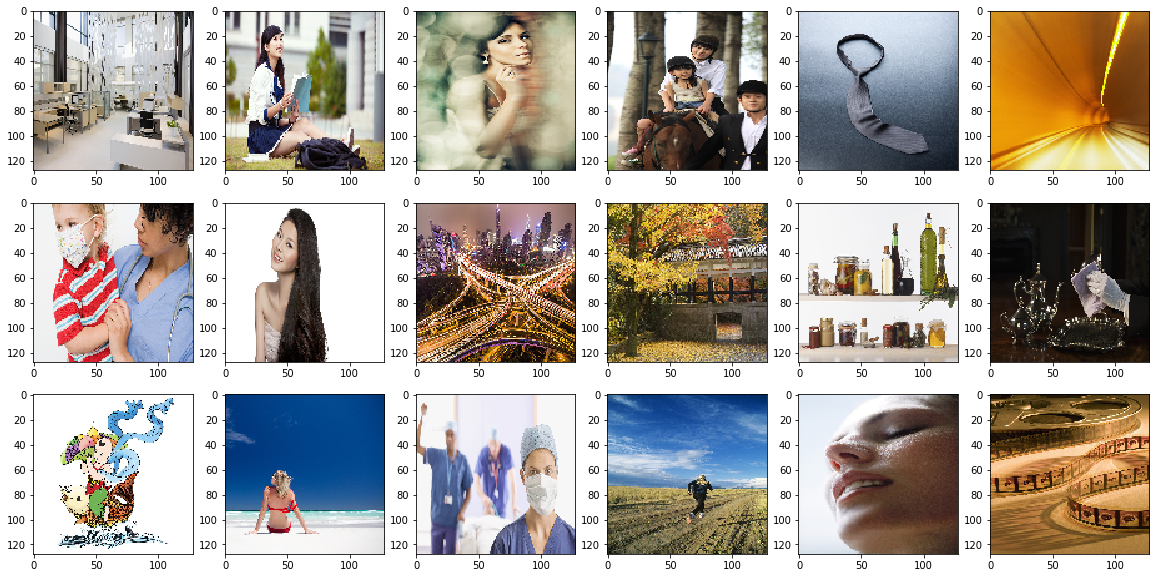

In [25]:
fig,axes = plt.subplots(3,6,figsize=(20, 10))

j = 0
for i,img in enumerate(X_train[:18]):
    axes[i//6,j%6].imshow(img)
    j+=1

In [26]:
import keras.backend as K

def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
    
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)


In [28]:
from sklearn.model_selection import train_test_split
# X_train2,X_val,y_train2,y_val = train_test_split(X_train, y_train[:nub_train], test_size=0.2, random_state=2018)
def load():
    f = h5py.File("dataset.h5")
    x = f['images'].value
    y = f['targets'].value
    f.close()
    x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=100)
    return x_train, x_test, y_train, y_test

X_train2,X_val,y_train2,y_val=load()

In [29]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
def train(model,save_name="vgg"):
    train_datagen = ImageDataGenerator(width_shift_range = 0.1, 
                                 height_shift_range = 0.1, 
                                 zoom_range = 0.1)
    val_datagen = ImageDataGenerator()     #验证集不做图片增强

    batch_size = 16

    train_generator = train_datagen.flow(X_train2,y_train2,batch_size=batch_size,shuffle=False) 
    val_generator = val_datagen.flow(X_val,y_val,batch_size=batch_size,shuffle=False)
    checkpointer = ModelCheckpoint(filepath=save_name+'_model.hdf5', 
                            monitor='val_fmeasure',verbose=1, save_best_only=True, mode='max')
    reduce = ReduceLROnPlateau(monitor='val_fmeasure',factor=0.5,patience=3,verbose=1,mode='max')

    model.compile(optimizer = 'adam',
           loss='binary_crossentropy',
           metrics=['accuracy',fmeasure,recall,precision])

    epochs = 100

    history = model.fit_generator(generator=train_generator,steps_per_epoch=X_train2.shape[0]//batch_size,
       validation_data = val_generator,validation_steps=X_val.shape[0]//batch_size,
       epochs=epochs,
       callbacks=[checkpointer,reduce],
       verbose=1)

In [50]:
from keras.layers import (
    Conv2D, BatchNormalization, Activation,
    MaxPooling2D, Dense, Flatten,Input,Dropout
)
from keras.models import Model, load_model
import os

class BaseModel():
    
    @staticmethod
    def base(input_shape,classes=100,weights="trained_model/vggnet.hdf5"):
        
        input_tensor = Input(shape=input_shape)
        x=Conv2D(32, kernel_size=(3, 3),padding='same')(input_tensor)
        x=Activation('relu')(x)
        x=Conv2D(64, (3, 3))(x)
        x=Activation('relu')(x)
        
        x=Conv2D(64,(3, 3), padding='same')(x)
        x=Activation('relu')(x)
        x=Conv2D(64, 3, 3)(x)
        x=Activation('relu')(x)
        x=MaxPooling2D(pool_size=(2, 2))(x)
        x=Dropout(0.25)(x)
        
        
        x=Flatten()(x)
        x=Dense(512)(x)
        x=Activation('relu')(x)
        x=Dense(classes)(x)
        out=Activation('sigmoid',name='predictions')(x)
        model = Model(input_tensor, out, name='model')
        
        if os.path.isfile(weights):
            model.load_weights(weights)
            print("Model loaded")
        else:
            print("No model is found")
            
        return model
        
    
        

In [ ]:
img_width=128
img_height=128
charset_size=6941
# model = Inception_v3.inception(input_shape=(img_width,img_height,3), classes=charset_size)
model=BaseModel.base(input_shape=(img_width,img_height,3), classes=charset_size)
model.summary()
train(model,"base")

/home/eric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`


No model is found
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
activation_19 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 126, 126, 64)      18496     
_________________________________________________________________
activation_20 (Activation)   (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 126, 126, 64)      36928     
_________________________________________________________________
activation_21 (Activation)   (None, 126, 126, 64)      0  

Epoch 12/100
1750/1750 [==============================] - 180s 103ms/step - loss: 0.0215 - acc: 0.9948 - fmeasure: 0.2328 - recall: 0.1400 - precision: 0.7100 - val_loss: 0.0218 - val_acc: 0.9948 - val_fmeasure: 0.2255 - val_recall: 0.1338 - val_precision: 0.7318
Epoch 13/100
1750/1750 [==============================] - 186s 106ms/step - loss: 0.0214 - acc: 0.9948 - fmeasure: 0.2348 - recall: 0.1414 - precision: 0.7102 - val_loss: 0.0218 - val_acc: 0.9948 - val_fmeasure: 0.2350 - val_recall: 0.1410 - val_precision: 0.7275
Epoch 14/100
1750/1750 [==============================] - 181s 104ms/step - loss: 0.0214 - acc: 0.9948 - fmeasure: 0.2351 - recall: 0.1416 - precision: 0.7101 - val_loss: 0.0219 - val_acc: 0.9948 - val_fmeasure: 0.2350 - val_recall: 0.1410 - val_precision: 0.7226
Epoch 15/100
 406/1750 [=====>........................] - ETA: 2:09 - loss: 0.0211 - acc: 0.9948 - fmeasure: 0.2417 - recall: 0.1462 - precision: 0.7151

In [16]:
X_train2.shape

(28000, 128, 128, 3)

In [17]:
y_train2.shape

(28000, 6941)

In [18]:
X_val.shape

(7000, 128, 128, 3)

In [19]:

width=128
height=128
nub_test = len(glob('valid/*'))
X_test = np.zeros((nub_test,width,height,3),dtype=np.uint8)
path = []
i = 0
for img_path in tqdm(glob('valid/*')):
    img = Image.open(img_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize((width,height))
    arr = np.asarray(img)
    X_test[i,:,:,:] = arr
    i += 1

100%|██████████| 8000/8000 [00:47<00:00, 166.93it/s]


In [20]:
from keras.models import load_model
img_width=128
img_height=128
charset_size=6941
# model = ResNet50.resnet(input_shape=(img_width,img_height,3), classes=charset_size,
#                        weights="resnet_model.hdf5")
# model.summary()
# # model=load_model("resnet_model.hdf5")
# model.compile(optimizer = 'adam',
#            loss='binary_crossentropy',
#            metrics=['accuracy',fmeasure,recall,precision])
y_pred = model.predict(X_test)
y_tags = arr2tag(y_pred)

In [21]:
import os
img_name = os.listdir('valid/')
img_name[:10]

['52cc3a4ae190abce1c407a802353e8fcc48a3a29.jpg',
 'fb8bb18ca7737a5b63f60eb8fedc30e7ebaf4066.jpg',
 '8c274f3d60d086ba95500886226a21919690195c.jpg',
 'cf81c83e658dafad5d27ea99eb251937dee517bd.jpg',
 'c32d750c5c9accf25d024538cd1189cc6d83a2b9.jpg',
 'abf7cf6246225ac113abc81268c10185174f822b.jpg',
 'e173a7c61218dcd9c53fcf066d8f3b06527254ef.jpg',
 '779393ca8af2270ca8266ce6994ab45ea6a988b8.jpg',
 'bdcf69d8e58602487eab8ad87d43c5fcd12776c2.jpg',
 '59edc1b18ca53f4d315f8ee66b9b6288ff487e9f.jpg']

In [22]:
# windows
import pandas as pd

df = pd.DataFrame({'img_path':img_name, 'tags':y_tags})
for i in range(df['tags'].shape[0]):
    df['tags'].iloc[i] = ','.join(str(e) for e in  df['tags'].iloc[i])
df.to_csv('submit.csv',index=None)

In [23]:
df.head()

,img_path,tags
0,52cc3a4ae190abce1c407a802353e8fcc48a3a29.jpg,"人,仅成年人,室内,彩色图片,成年人,摄影,水平画幅,黑白图片"
1,fb8bb18ca7737a5b63f60eb8fedc30e7ebaf4066.jpg,"彩色图片,摄影,无人,水平画幅"
2,8c274f3d60d086ba95500886226a21919690195c.jpg,"一个人,专业人员,东亚,东方人,中国,中国人,亚洲,亚洲人,亚洲人和印度人,人,仅成年人,信..."
3,cf81c83e658dafad5d27ea99eb251937dee517bd.jpg,"人,人群,仅成年人,彩色图片,成年人,摄影,水平画幅,男人,站"
4,c32d750c5c9accf25d024538cd1189cc6d83a2b9.jpg,"人,仅成年人,室内,彩色图片,成年人,摄影,水平画幅"
